In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from models.transformers import DecoderOnlyTransformer
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import yaml
import gc
import torch
from torchinfo import summary
import os
import json
import shutil
import wandb
import yaml
from data.datasets import CFGDataset, verify_dataloader
from trainers.GPT_trainer import GPT_Trainer
from trainers.utils import create_optimizer, create_scheduler


device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

#Read config yaml file
with open("config.yaml", "r") as f:
    config = yaml.safe_load(f)
print(f"Config loaded successfully.")



Using device: cuda
Config loaded successfully.


#### Loading Data

In [3]:
train_dataset =  CFGDataset(
    data_file="cfg_sentences_train_cfg3b.npy", 
    batch_size = config["data"]["batch_size"],
    seq_len = config["data"]["seq_len"],
    eos_token = config["data"]["eos_token"],
    sos_token = config["data"]["sos_token"],
    ) 

val_dataset =  CFGDataset(
    data_file="cfg_sentences_val_cfg3b.npy", 
    
    batch_size = config["data"]["batch_size"],
    seq_len = config["data"]["seq_len"],
    eos_token = config["data"]["eos_token"],
    sos_token = config["data"]["sos_token"],
    ) 


train_loader = DataLoader(train_dataset, 
                          batch_size = None, 
                          num_workers=config["data"]["NUM_WORKERS"] if device == "cuda" else 0, 
                          pin_memory=True)

val_loader = DataLoader(val_dataset, 
                        batch_size=None, 
                        num_workers=config["data"]["NUM_WORKERS"] if device == "cuda" else 0,
                        pin_memory=True)

verify_dataloader(train_loader)
print("_"*50)
verify_dataloader(val_loader)
#print("="*50)
#print("Verify Validation DataLoader")
#verify_dataloader(val_loader)

Verifying dataloader...
Number of batches:  40669
Total number of tokens:  1.998977e+09


Example batch shapes (shifted, golden):  torch.Size([96, 512]) torch.Size([96, 512])
__________________________________________________
Verifying dataloader...
Number of batches:  4518
Total number of tokens:  2.221086e+08
Example batch shapes (shifted, golden):  torch.Size([96, 512]) torch.Size([96, 512])


In [4]:
model_config = {}
model_config = config['model'].copy()

model_config.update({
    'num_classes': config["data"]["vocab_size"] +2 ,#include SOS and ESO tolen
    'seq_len': config["data"]["seq_len"],
    })

model = DecoderOnlyTransformer(**model_config)

for batch in train_loader:
    shifted_transcripts, golden_transcripts = batch
    print("Shape of shifted_transcripts : ", shifted_transcripts.shape)
    print("Shape of golden_transcripts  : ", golden_transcripts.shape)
    break

#model_stats = summary(model, input_data=[shifted_transcripts])
#print(model_stats)
print(f"Total parameters in the model: {sum(p.numel() for p in model.parameters()):,}")
#torch._dynamo.config.skip_nnmodule_hook_guards = False
#model = torch.compile(model, mode="default", fullgraph=True)


Shape of shifted_transcripts :  torch.Size([96, 512])
Shape of golden_transcripts  :  torch.Size([96, 512])
Total parameters in the model: 42,532,613


In [5]:
#get total memory space used by data
#total_memory = torch.cuda.memory_allocated(device) / (1024 ** 3)
#print(f"Total memory used by data: {total_memory:.2f} GB")

Using device: cuda


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: lucasfragara (teamlsfr) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin



🔧 Configuring Optimizer:
├── Type: ADAMW
├── Base LR: 0.0007
├── Weight Decay: 0.1
├── Parameter Groups:
│   ├── Group: self_attn
│   │   ├── LR: 0.0007
│   │   └── Patterns: []
│   ├── Group: ffn
│   │   ├── LR: 0.0007
│   │   └── Patterns: []
│   └── Default Group (unmatched parameters)
└── AdamW Specific:
    ├── Betas: [0.9, 0.98]
    ├── Epsilon: 1e-08
    └── AMSGrad: False


/jet/home/sfragara/.conda/envs/env/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



📈 Configuring Learning Rate Scheduler:
├── Type: COSINE
├── Cosine Annealing Settings:
│   ├── T_max: 40669 steps
│   └── Min LR: 1e-08
└── Warmup: Disabled


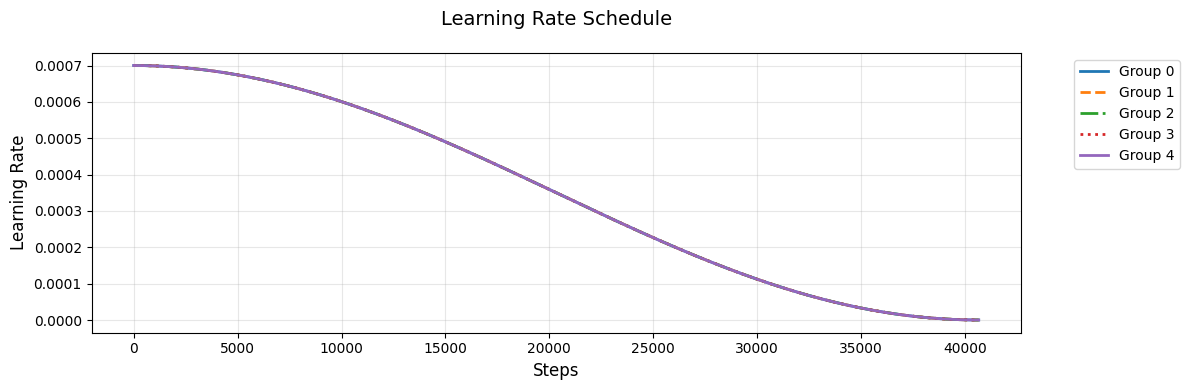

In [6]:
from trainers.utils.create_scheduler import plot_lr_schedule


torch.cuda.empty_cache()
gc.collect()

trainer = GPT_Trainer(
    model = model, 
    config = config,
    config_file = "config.yaml",
    run_name = "test", 
    device = device
)

trainer.optimizer = create_optimizer.create_optimizer(
    model = model, 
    opt_config = config["optimizer"]
)

trainer.scheduler = create_scheduler.create_scheduler(
    optimizer=trainer.optimizer,
    scheduler_config=config['scheduler'],
    train_loader=train_loader,
    gradient_accumulation_steps=config['training']['gradient_accumulation_steps']
)

plot_lr_schedule(trainer.scheduler, num_epochs=len(train_loader), train_loader=train_loader)

#trainer.load_checkpoint("/ocean/projects/cis250019p/sfragara/lstm/expts/test/checkpoints/checkpoint-best-metric-model.pth")

In [ ]:
trainer.model.train()

trainer.train_epoch(
    train_dataloader=train_loader,
    val_dataloader=val_loader,
)

wandb metrics being logged:  {'train/ce_loss_token': 1.4153383297495323, 'train/perplexity_token': 4.117879390716553, 'val/ce_loss_token': 1.2705635683877128, 'val/perplexity_token': 3.5628600120544434, 'learning_rate': 0.0006999893476568829}

📊 Metrics (Epoch 100):
├── TRAIN:
│   ├── ce_loss_token: 1.4153
│   └── perplexity_token: 4.1179
└── VAL:
    ├── ce_loss_token: 1.2706
    └── perplexity_token: 3.5629
└── TRAINING:
    └── learning_rate: 0.000700


wandb: WARNING Saving files without folders. If you want to preserve subdirectories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")


wandb metrics being logged:  {'train/ce_loss_token': 1.3434633004724683, 'train/perplexity_token': 3.8322930335998535, 'val/ce_loss_token': 1.2695632321493966, 'val/perplexity_token': 3.559297561645508, 'learning_rate': 0.000699957812091826}

📊 Metrics (Epoch 200):
├── TRAIN:
│   ├── ce_loss_token: 1.3435
│   └── perplexity_token: 3.8323
└── VAL:
    ├── ce_loss_token: 1.2696
    └── perplexity_token: 3.5593
└── TRAINING:
    └── learning_rate: 0.000700


wandb metrics being logged:  {'train/ce_loss_token': 1.3188371424659147, 'train/perplexity_token': 3.7390708923339844, 'val/ce_loss_token': 1.2642830269677299, 'val/perplexity_token': 3.540553569793701, 'learning_rate': 0.0006999053941423708}

📊 Metrics (Epoch 300):
├── TRAIN:
│   ├── ce_loss_token: 1.3188
│   └── perplexity_token: 3.7391
└── VAL:
    ├── ce_loss_token: 1.2643
    └── perplexity_token: 3.5406
└── TRAINING:
    └── learning_rate: 0.000700


wandb metrics being logged:  {'train/ce_loss_token': 1.2989222061009775, 'train/perplexity_token': 3.665343999862671, 'val/ce_loss_token': 1.191757219178336, 'val/perplexity_token': 3.2928624153137207, 'learning_rate': 0.0006998320969364004}

📊 Metrics (Epoch 400):
├── TRAIN:
│   ├── ce_loss_token: 1.2989
│   └── perplexity_token: 3.6653
└── VAL:
    ├── ce_loss_token: 1.1918
    └── perplexity_token: 3.2929
└── TRAINING:
    └── learning_rate: 0.000700


wandb metrics being logged:  {'train/ce_loss_token': 1.2783329137071164, 'train/perplexity_token': 3.590648889541626, 'val/ce_loss_token': 1.1679083960396903, 'val/perplexity_token': 3.2152607440948486, 'learning_rate': 0.0006997379248477051}

📊 Metrics (Epoch 500):
├── TRAIN:
│   ├── ce_loss_token: 1.2783
│   └── perplexity_token: 3.5906
└── VAL:
    ├── ce_loss_token: 1.1679
    └── perplexity_token: 3.2153
└── TRAINING:
    └── learning_rate: 0.000700


wandb metrics being logged:  {'train/ce_loss_token': 1.260795346115671, 'train/perplexity_token': 3.528226613998413, 'val/ce_loss_token': 1.1657753842217582, 'val/perplexity_token': 3.2084097862243652, 'learning_rate': 0.0006996228834957227}

📊 Metrics (Epoch 600):
├── TRAIN:
│   ├── ce_loss_token: 1.2608
│   └── perplexity_token: 3.5282
└── VAL:
    ├── ce_loss_token: 1.1658
    └── perplexity_token: 3.2084
└── TRAINING:
    └── learning_rate: 0.000700


wandb metrics being logged:  {'train/ce_loss_token': 1.2469507134419875, 'train/perplexity_token': 3.4797163009643555, 'val/ce_loss_token': 1.1602495057242257, 'val/perplexity_token': 3.1907291412353516, 'learning_rate': 0.0006994869797452001}

📊 Metrics (Epoch 700):
├── TRAIN:
│   ├── ce_loss_token: 1.2470
│   └── perplexity_token: 3.4797
└── VAL:
    ├── ce_loss_token: 1.1602
    └── perplexity_token: 3.1907
└── TRAINING:
    └── learning_rate: 0.000699


wandb metrics being logged:  {'train/ce_loss_token': 1.2363576033291002, 'train/perplexity_token': 3.443049430847168, 'val/ce_loss_token': 1.161023463521685, 'val/perplexity_token': 3.193199872970581, 'learning_rate': 0.0006993302217057863}

📊 Metrics (Epoch 800):
├── TRAIN:
│   ├── ce_loss_token: 1.2364
│   └── perplexity_token: 3.4430
└── VAL:
    ├── ce_loss_token: 1.1610
    └── perplexity_token: 3.1932
└── TRAINING:
    └── learning_rate: 0.000699


wandb metrics being logged:  {'train/ce_loss_token': 1.2281199455525846, 'train/perplexity_token': 3.4148035049438477, 'val/ce_loss_token': 1.15960316998618, 'val/perplexity_token': 3.1886675357818604, 'learning_rate': 0.0006991526187315471}

📊 Metrics (Epoch 900):
├── TRAIN:
│   ├── ce_loss_token: 1.2281
│   └── perplexity_token: 3.4148
└── VAL:
    ├── ce_loss_token: 1.1596
    └── perplexity_token: 3.1887
└── TRAINING:
    └── learning_rate: 0.000699


wandb metrics being logged:  {'train/ce_loss_token': 1.2182152916144182, 'train/perplexity_token': 3.381148099899292, 'val/ce_loss_token': 0.9349282213619777, 'val/perplexity_token': 2.5470306873321533, 'learning_rate': 0.0006989541814204076}

📊 Metrics (Epoch 1000):
├── TRAIN:
│   ├── ce_loss_token: 1.2182
│   └── perplexity_token: 3.3811
└── VAL:
    ├── ce_loss_token: 0.9349
    └── perplexity_token: 2.5470
└── TRAINING:
    └── learning_rate: 0.000699


wandb metrics being logged:  {'train/ce_loss_token': 1.1527384579668902, 'train/perplexity_token': 3.166853427886963, 'val/ce_loss_token': 0.39734828046389986, 'val/perplexity_token': 1.4878740310668945, 'learning_rate': 0.0006987349216135188}

📊 Metrics (Epoch 1100):
├── TRAIN:
│   ├── ce_loss_token: 1.1527
│   └── perplexity_token: 3.1669
└── VAL:
    ├── ce_loss_token: 0.3973
    └── perplexity_token: 1.4879
└── TRAINING:
    └── learning_rate: 0.000699


wandb metrics being logged:  {'train/ce_loss_token': 1.0896585554157467, 'train/perplexity_token': 2.9732584953308105, 'val/ce_loss_token': 0.39314186573028564, 'val/perplexity_token': 1.4816285371780396, 'learning_rate': 0.0006984948523945518}

📊 Metrics (Epoch 1200):
├── TRAIN:
│   ├── ce_loss_token: 1.0897
│   └── perplexity_token: 2.9733
└── VAL:
    ├── ce_loss_token: 0.3931
    └── perplexity_token: 1.4816
└── TRAINING:
    └── learning_rate: 0.000698


wandb metrics being logged:  {'train/ce_loss_token': 1.0361040020612091, 'train/perplexity_token': 2.818215847015381, 'val/ce_loss_token': 0.3916940561362675, 'val/perplexity_token': 1.479485034942627, 'learning_rate': 0.000698233988088917}

📊 Metrics (Epoch 1300):
├── TRAIN:
│   ├── ce_loss_token: 1.0361
│   └── perplexity_token: 2.8182
└── VAL:
    ├── ce_loss_token: 0.3917
    └── perplexity_token: 1.4795
└── TRAINING:
    └── learning_rate: 0.000698


wandb metrics being logged:  {'train/ce_loss_token': 0.9901370476349007, 'train/perplexity_token': 2.691603422164917, 'val/ce_loss_token': 0.3929638053689684, 'val/perplexity_token': 1.4813647270202637, 'learning_rate': 0.0006979523442629106}

📊 Metrics (Epoch 1400):
├── TRAIN:
│   ├── ce_loss_token: 0.9901
│   └── perplexity_token: 2.6916
└── VAL:
    ├── ce_loss_token: 0.3930
    └── perplexity_token: 1.4814
└── TRAINING:
    └── learning_rate: 0.000698


wandb metrics being logged:  {'train/ce_loss_token': 0.9503251519662234, 'train/perplexity_token': 2.58655047416687, 'val/ce_loss_token': 0.3936582846300943, 'val/perplexity_token': 1.4823938608169556, 'learning_rate': 0.0006976499377227822}

📊 Metrics (Epoch 1500):
├── TRAIN:
│   ├── ce_loss_token: 0.9503
│   └── perplexity_token: 2.5866
└── VAL:
    ├── ce_loss_token: 0.3937
    └── perplexity_token: 1.4824
└── TRAINING:
    └── learning_rate: 0.000698


wandb metrics being logged:  {'train/ce_loss_token': 0.9156110505250601, 'train/perplexity_token': 2.4983012676239014, 'val/ce_loss_token': 0.39193572316850933, 'val/perplexity_token': 1.4798426628112793, 'learning_rate': 0.000697326786513735}

📊 Metrics (Epoch 1600):
├── TRAIN:
│   ├── ce_loss_token: 0.9156
│   └── perplexity_token: 2.4983
└── VAL:
    ├── ce_loss_token: 0.3919
    └── perplexity_token: 1.4798
└── TRAINING:
    └── learning_rate: 0.000697


wandb metrics being logged:  {'train/ce_loss_token': 0.8848183661751856, 'train/perplexity_token': 2.422544240951538, 'val/ce_loss_token': 0.3942274408681052, 'val/perplexity_token': 1.483237862586975, 'learning_rate': 0.0006969829099188478}

📊 Metrics (Epoch 1700):
├── TRAIN:
│   ├── ce_loss_token: 0.8848
│   └── perplexity_token: 2.4225
└── VAL:
    ├── ce_loss_token: 0.3942
    └── perplexity_token: 1.4832
└── TRAINING:
    └── learning_rate: 0.000697


wandb metrics being logged:  {'train/ce_loss_token': 0.8574347267178679, 'train/perplexity_token': 2.3571064472198486, 'val/ce_loss_token': 0.3913844270365579, 'val/perplexity_token': 1.4790270328521729, 'learning_rate': 0.000696618328457926}

📊 Metrics (Epoch 1800):
├── TRAIN:
│   ├── ce_loss_token: 0.8574
│   └── perplexity_token: 2.3571
└── VAL:
    ├── ce_loss_token: 0.3914
    └── perplexity_token: 1.4790
└── TRAINING:
    └── learning_rate: 0.000697


wandb metrics being logged:  {'train/ce_loss_token': 0.832934207551922, 'train/perplexity_token': 2.3000576496124268, 'val/ce_loss_token': 0.39177291733878, 'val/perplexity_token': 1.4796017408370972, 'learning_rate': 0.000696233063886274}

📊 Metrics (Epoch 1900):
├── TRAIN:
│   ├── ce_loss_token: 0.8329
│   └── perplexity_token: 2.3001
└── VAL:
    ├── ce_loss_token: 0.3918
    └── perplexity_token: 1.4796
└── TRAINING:
    └── learning_rate: 0.000696


wandb metrics being logged:  {'train/ce_loss_token': 0.8108764995580193, 'train/perplexity_token': 2.2498791217803955, 'val/ce_loss_token': 0.3913902853216444, 'val/perplexity_token': 1.4790356159210205, 'learning_rate': 0.0006958271391933999}

📊 Metrics (Epoch 2000):
├── TRAIN:
│   ├── ce_loss_token: 0.8109
│   └── perplexity_token: 2.2499
└── VAL:
    ├── ce_loss_token: 0.3914
    └── perplexity_token: 1.4790
└── TRAINING:
    └── learning_rate: 0.000696


wandb metrics being logged:  {'train/ce_loss_token': 0.790908887649025, 'train/perplexity_token': 2.205399990081787, 'val/ce_loss_token': 0.3912916992391859, 'val/perplexity_token': 1.4788898229599, 'learning_rate': 0.0006954005786016428}

📊 Metrics (Epoch 2100):
├── TRAIN:
│   ├── ce_loss_token: 0.7909
│   └── perplexity_token: 2.2054
└── VAL:
    ├── ce_loss_token: 0.3913
    └── perplexity_token: 1.4789
└── TRAINING:
    └── learning_rate: 0.000695


wandb metrics being logged:  {'train/ce_loss_token': 0.7727506639116842, 'train/perplexity_token': 2.165715217590332, 'val/ce_loss_token': 0.39127390725272043, 'val/perplexity_token': 1.4788635969161987, 'learning_rate': 0.0006949534075647252}

📊 Metrics (Epoch 2200):
├── TRAIN:
│   ├── ce_loss_token: 0.7728
│   └── perplexity_token: 2.1657
└── VAL:
    ├── ce_loss_token: 0.3913
    └── perplexity_token: 1.4789
└── TRAINING:
    └── learning_rate: 0.000695


wandb metrics being logged:  {'train/ce_loss_token': 0.75617618553797, 'train/perplexity_token': 2.130115509033203, 'val/ce_loss_token': 0.391413722719465, 'val/perplexity_token': 1.4790703058242798, 'learning_rate': 0.0006944856527662379}

📊 Metrics (Epoch 2300):
├── TRAIN:
│   ├── ce_loss_token: 0.7562
│   └── perplexity_token: 2.1301
└── VAL:
    ├── ce_loss_token: 0.3914
    └── perplexity_token: 1.4791
└── TRAINING:
    └── learning_rate: 0.000694


wandb metrics being logged:  {'train/ce_loss_token': 0.740981677344619, 'train/perplexity_token': 2.097994089126587, 'val/ce_loss_token': 0.39142609919820515, 'val/perplexity_token': 1.479088544845581, 'learning_rate': 0.0006939973421180456}

📊 Metrics (Epoch 2400):
├── TRAIN:
│   ├── ce_loss_token: 0.7410
│   └── perplexity_token: 2.0980
└── VAL:
    ├── ce_loss_token: 0.3914
    └── perplexity_token: 1.4791
└── TRAINING:
    └── learning_rate: 0.000694


wandb metrics being logged:  {'train/ce_loss_token': 0.72700384880056, 'train/perplexity_token': 2.0688726902008057, 'val/ce_loss_token': 0.39129125646182467, 'val/perplexity_token': 1.4788892269134521, 'learning_rate': 0.0006934885047586219}

📊 Metrics (Epoch 2500):
├── TRAIN:
│   ├── ce_loss_token: 0.7270
│   └── perplexity_token: 2.0689
└── VAL:
    ├── ce_loss_token: 0.3913
    └── perplexity_token: 1.4789
└── TRAINING:
    └── learning_rate: 0.000693


wandb metrics being logged:  {'train/ce_loss_token': 0.7140977702682544, 'train/perplexity_token': 2.0423431396484375, 'val/ce_loss_token': 0.39222483549799236, 'val/perplexity_token': 1.480270504951477, 'learning_rate': 0.0006929591710513099}

📊 Metrics (Epoch 2600):
├── TRAIN:
│   ├── ce_loss_token: 0.7141
│   └── perplexity_token: 2.0423
└── VAL:
    ├── ce_loss_token: 0.3922
    └── perplexity_token: 1.4803
└── TRAINING:
    └── learning_rate: 0.000693


wandb metrics being logged:  {'train/ce_loss_token': 0.7021578025901728, 'train/perplexity_token': 2.0181026458740234, 'val/ce_loss_token': 0.3914363511971065, 'val/perplexity_token': 1.4791038036346436, 'learning_rate': 0.0006924093725825109}

📊 Metrics (Epoch 2700):
├── TRAIN:
│   ├── ce_loss_token: 0.7022
│   └── perplexity_token: 2.0181
└── VAL:
    ├── ce_loss_token: 0.3914
    └── perplexity_token: 1.4791
└── TRAINING:
    └── learning_rate: 0.000692


wandb metrics being logged:  {'train/ce_loss_token': 0.6910579945095434, 'train/perplexity_token': 1.995826005935669, 'val/ce_loss_token': 0.3911286209310804, 'val/perplexity_token': 1.4786486625671387, 'learning_rate': 0.0006918391421597988}

📊 Metrics (Epoch 2800):
├── TRAIN:
│   ├── ce_loss_token: 0.6911
│   └── perplexity_token: 1.9958
└── VAL:
    ├── ce_loss_token: 0.3911
    └── perplexity_token: 1.4786
└── TRAINING:
    └── learning_rate: 0.000692


wandb metrics being logged:  {'train/ce_loss_token': 0.6807260780201333, 'train/perplexity_token': 1.9753113985061646, 'val/ce_loss_token': 0.39114671094076975, 'val/perplexity_token': 1.4786754846572876, 'learning_rate': 0.0006912485138099643}

📊 Metrics (Epoch 2900):
├── TRAIN:
│   ├── ce_loss_token: 0.6807
│   └── perplexity_token: 1.9753
└── VAL:
    ├── ce_loss_token: 0.3911
    └── perplexity_token: 1.4787
└── TRAINING:
    └── learning_rate: 0.000691


wandb metrics being logged:  {'train/ce_loss_token': 0.6710772041339391, 'train/perplexity_token': 1.9563435316085815, 'val/ce_loss_token': 0.3912772834300995, 'val/perplexity_token': 1.4788684844970703, 'learning_rate': 0.0006906375227769823}

📊 Metrics (Epoch 3000):
├── TRAIN:
│   ├── ce_loss_token: 0.6711
│   └── perplexity_token: 1.9563
└── VAL:
    ├── ce_loss_token: 0.3913
    └── perplexity_token: 1.4789
└── TRAINING:
    └── learning_rate: 0.000691


wandb metrics being logged:  {'train/ce_loss_token': 0.6620551699863176, 'train/perplexity_token': 1.9387727975845337, 'val/ce_loss_token': 0.39116337043898447, 'val/perplexity_token': 1.478700041770935, 'learning_rate': 0.0006900062055199103}

📊 Metrics (Epoch 3100):
├── TRAIN:
│   ├── ce_loss_token: 0.6621
│   └── perplexity_token: 1.9388
└── VAL:
    ├── ce_loss_token: 0.3912
    └── perplexity_token: 1.4787
└── TRAINING:
    └── learning_rate: 0.000690


wandb metrics being logged:  {'train/ce_loss_token': 0.6535920765913118, 'train/perplexity_token': 1.9224339723587036, 'val/ce_loss_token': 0.39143563168389456, 'val/perplexity_token': 1.4791027307510376, 'learning_rate': 0.0006893545997107121}

📊 Metrics (Epoch 3200):
├── TRAIN:
│   ├── ce_loss_token: 0.6536
│   └── perplexity_token: 1.9224
└── VAL:
    ├── ce_loss_token: 0.3914
    └── perplexity_token: 1.4791
└── TRAINING:
    └── learning_rate: 0.000689
